<a href="https://colab.research.google.com/github/PGV1000/data_mining/blob/main/%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%9F%D0%A0_%E2%84%967_%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №7. Применение методов машинного обучения для решения задач классификации текстов. Метод Наивного Байеса. Метод опорных векторов**

## Задание 0. Найдите в глобальной сети или соберите свой датасет для классификации текстов (Пример: новости -> рубрики, комментарии в соц. сетях -> характер, )

* Количество классов в датасете должно превышать 2
* Язык текста в датасете: русский

- ### Пример датасетов: [Russian Texts](https://www.kaggle.com/datasets?search=text+classification+russian)

In [115]:
import kagglehub
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Загрузите датасет

In [84]:
path = kagglehub.dataset_download("mikhailma/russian-social-media-text-classification")
!cp -r {path} .
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mikhailma/russian-social-media-text-classification/versions/1


In [85]:
ds = pd.read_csv('/content/1/train.csv')
ds = ds.drop(columns='oid')
ds.dropna(inplace=True)
ds['category'] = ds['category'].astype('category')
category_mapping = dict(enumerate(ds['category'].cat.categories))
ds['category'] = ds['category'].cat.codes
ds

,category,text
0,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,5,Возвращение в подземелье Треша 33 Эйфория тупо...
2,6,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,3,Rtokenoid Warhammer40k валрак решил нас подкор...
4,7,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...
38735,1,8 битная буря снова накрыла пикселями автомоби...
38736,1,Ира Сидоркова объясняет как сказалась на ее ма...
38737,10,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,11,Стал известен календарь мужской сборной России...


### Разделите данные на обучающую и валидационную выборки

In [86]:
x_train, x_test, y_train, y_test = train_test_split(ds['text'], ds['category'], test_size=0.2, random_state=1)
x_train.shape, x_test.shape

((30992,), (7748,))

### При выполении дальнейших заданий поэксперементируйте с методами векторизации текста:


1. [Bag of Words](https://habr.com/ru/companies/mlclass/articles/270591/) (BOW): Bag of Words представляет текст как вектор, где каждый элемент обозначает количество вхождений конкретного слова в тексте. Процесс включает в себя создание словаря всех уникальных слов в корпусе текстов и подсчет частоты встречаемости каждого слова в отдельных текстах.

2. [TF-IDF](https://habr.com/ru/companies/otus/articles/755772/) (Term Frequency-Inverse Document Frequency): TF-IDF учитывает не только количество вхождений слова в текст, но и частоту его встречаемости в других текстах. Он вычисляет вес слова, умножая его частоту встречаемости (term frequency) на обратную частоту документа (inverse document frequency). Это позволяет снизить вес наиболее часто встречающихся слов, которые могут быть менее информативными.

3. Word Embeddings (например, [Word2Vec](https://habr.com/ru/articles/446530/) и [GloVe](https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6)): Word Embeddings используют нейронные сети для создания векторных представлений слов, которые учитывают семантическую близость между словами. Нейронные сети обучаются на больших текстовых корпусах и захватывают семантические отношения между словами, что позволяет представить слова в векторном пространстве.

4. One-Hot Encoding: One-Hot Encoding преобразует каждое слово в уникальный вектор, где все элементы равны нулю, за исключением одного, который равен единице. Каждый вектор соответствует отдельному слову и используется для представления его в пространстве признаков.

5. [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): Count Vectorizer подсчитывает количество раз, которое каждое слово встречается в тексте. Он создает вектор, в котором каждый элемент соответствует количеству вхождений конкретного слова в текст.

6. [Hashing Vectorizer](https://kavita-ganesan.com/hashingvectorizer-vs-countvectorizer/): Hashing Vectorizer преобразует каждое слово в уникальный числовой идентификатор с помощью хеширования. Он использует хеш-функцию для преобразования слова в числовое значение, которое затем используется в векторном представлении.

7. [Doc2Vec](https://habr.com/ru/articles/599513/): Doc2Vec является расширением метода Word2Vec и позволяет получить векторное представление не только отдельных слов, но и целых документов или текстов. Алгоритм обучает нейронную сеть, которая учитывает контекст и порядок слов в предложении, чтобы получить векторное представление документа. Это позволяет сравнивать и измерять семантическую близость между целыми текстовыми документами.

#### Оцените влияние разных методов на конечный результат

## Задание 1. Обучите модель классификатора Naive Bayes для решения поставленной задачи, используя пайплайн и подбор оптимальных параметров

In [87]:
# Определение шагов конвейера
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),      # Преобразование текста в числовые признаки
    ('classifier', MultinomialNB())         # Мультиномиальный наивный байесовский классификатор
])

In [88]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [89]:
y_pred = pipeline.predict(x_test)

In [90]:
x_custom = ['Тренер «Манчестер Сити» Гвардиола высказался о разгромной победе над «Вест Хэмом»']
y_pred_custom = pipeline.predict(x_custom)
answer = (category_mapping[y_pred_custom[0]])
print(f'Прогноз: {answer}')

Прогноз: football


### Вывод матрицы ошибок:

<Axes: >

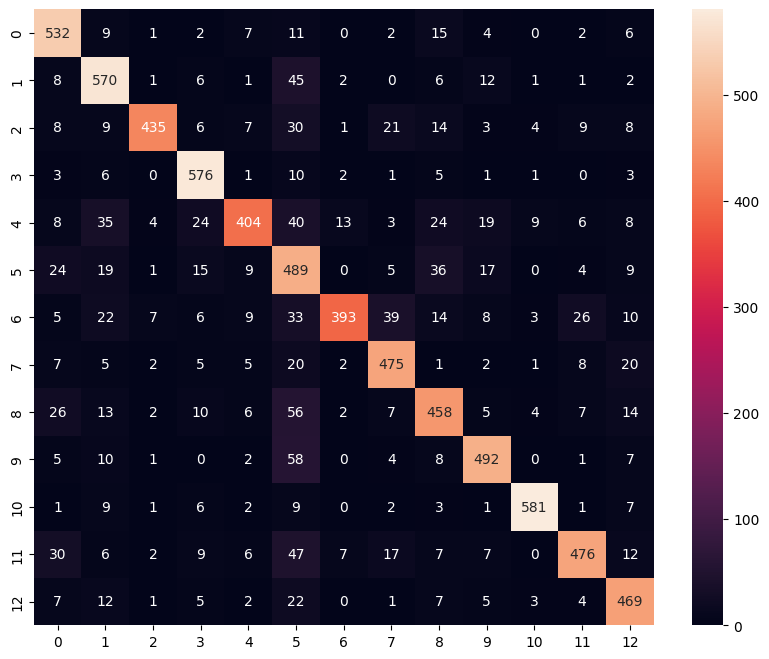

In [91]:
conf_mat_NB=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_NB,annot=True,fmt='d')

### Оценка точности:

In [92]:
naive_acc=accuracy_score(y_test,y_pred)
naive_acc

0.8195663397005679

In [93]:
param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],   # Униграммы* или униграммы+биграммы*
    'classifier__alpha': [0.5, 0.75, 1.0]                # Параметр сглаживания для Naive Bayes
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшие параметры: {'classifier__alpha': 0.5, 'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 1)}


In [94]:
y_pred_gs = grid_search.predict(x_test)

In [95]:
naive_acc=accuracy_score(y_test,y_pred_gs)
naive_acc

0.8434434692823954

<Axes: >

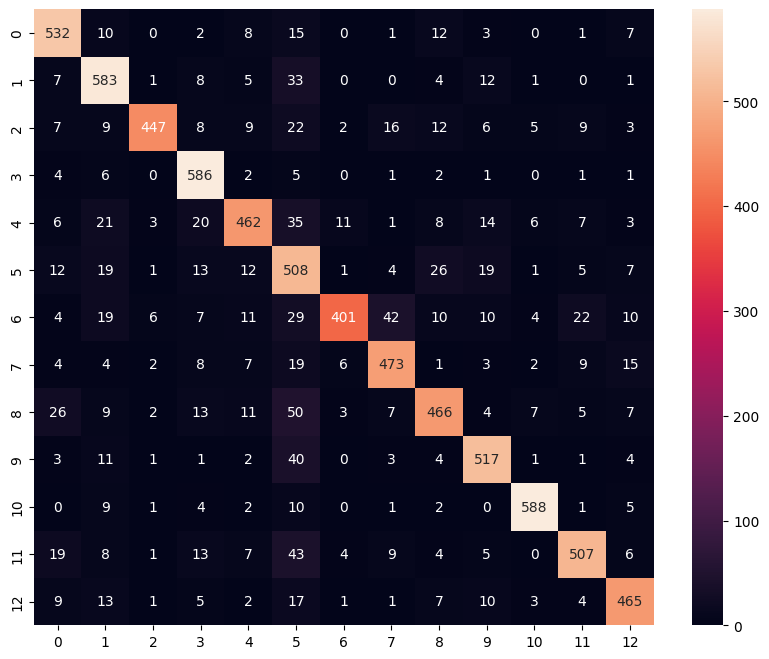

In [96]:
conf_mat_NB=confusion_matrix(y_test, y_pred_gs)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_NB,annot=True,fmt='d')

## Задание 2. Обучите модель SVM (метод опорных векторов) для решения поставленной задачи, используя пайплайны и подбор оптимальных параметров

In [97]:
clf_svm= Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('svc', SVC(kernel="rbf",C=1000,gamma=0.001))
])

In [98]:
clf_svm.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('svc', SVC(C=1000, gamma=0.001))])

In [99]:
y_pred_SVM=clf_svm.predict(x_test)

### Вывод матрицы ошибок:

<Axes: >

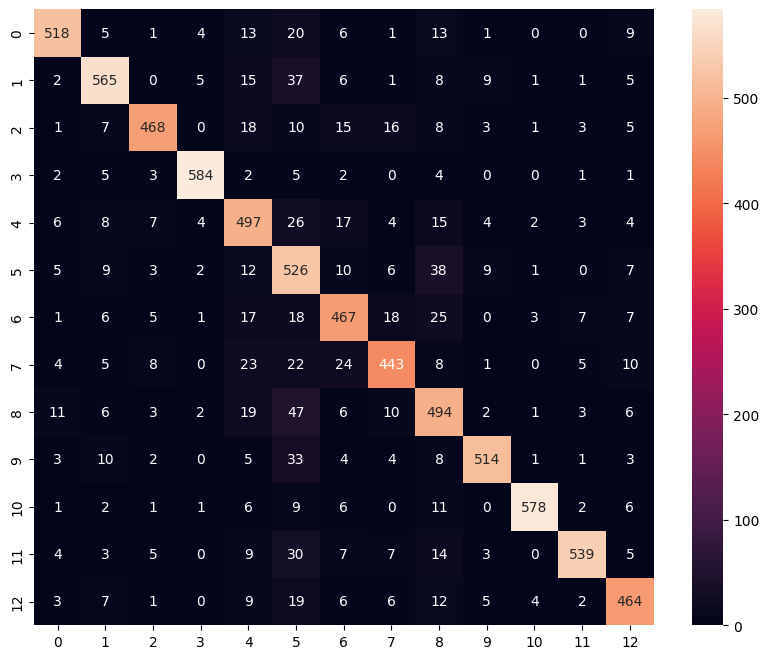

In [100]:
conf_mat_NB=confusion_matrix(y_test, y_pred_SVM)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_NB,annot=True,fmt='d')

### Оценка точности:

In [101]:
svm_acc=accuracy_score(y_test,y_pred_SVM)
svm_acc

0.859189468249871

## Задание 3. Обучите модель классификатора Decision Tree Classifier для решения поставленной задачи

In [104]:
clf_DecisionTree= Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('dt',DecisionTreeClassifier())
])

In [106]:
clf_DecisionTree.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier())])

In [107]:
y_pred_dt = clf_DecisionTree.predict(x_test)

### Вывод матрицы ошибок:

<Axes: >

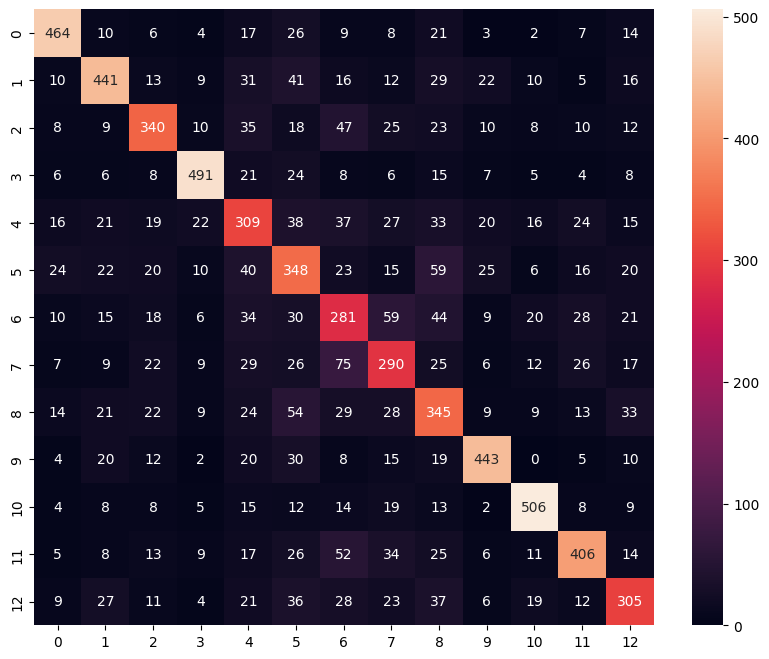

In [108]:
conf_mat_NB=confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_NB, annot=True, fmt='d')

### Оценка точности:

In [109]:
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_acc

0.6413267940113577

## Задание 4. Обучите модель классификатора Random Forest Classifier для решения поставленной задачи

In [116]:
clf_rf= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [118]:
clf_rf.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [119]:
y_pred_RF=clf_rf.predict(x_test)

### Вывод матрицы ошибок:

In [120]:
conf_mat_RF=confusion_matrix(y_test, y_pred_RF)

<Axes: >

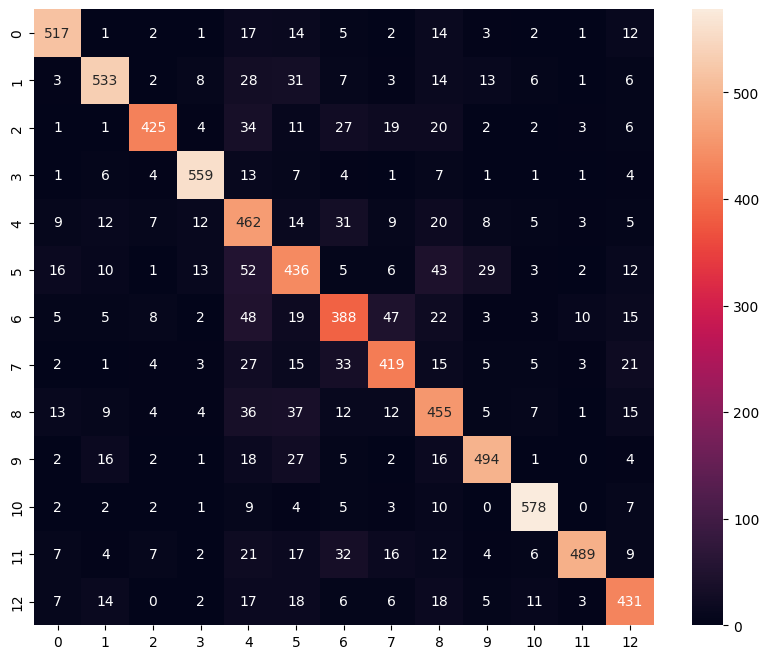

In [121]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_RF,annot=True,fmt='d')

### Оценка точности:

In [122]:
rf_acc = accuracy_score(y_test, y_pred_RF)
rf_acc

0.798399586990191

## Подведите общие итоги и сделайте выводы

In [124]:
print(f'Точность наивного байесовского классификатора: {naive_acc}')
print(f'Точность опорных векторов: {svm_acc}')
print(f'Точность дерева решений: {dt_acc}')
print(f'Точность случайного леса: {rf_acc}')

Точность наивного байесовского классификатора: 0.8434434692823954
Точность опорных векторов: 0.859189468249871
Точность дерева решений: 0.6413267940113577
Точность случайного леса: 0.798399586990191


Лучшая точность получена при использовании метода опорных векторов, однако он не сильно уступает наивному байесовскому классификатору в тоже время сильно проигрывая в скорости обучения.